# CAB_420-A2: Enron Email Sender Identification

# 1. Imports and Functions

In [35]:
# Imports
# pip install -r requirements.txt

# to set up the venv, run
# pip install keras matplotlib seaborn scikit-learn scikit-image statsmodels opencv-python pandas gensim pillow tensorflow-datasets xgboost jupyter ipython jupyterlab openpyxl


# Imports
import tarfile
import os
import sys
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import hashlib
import re

from tqdm.notebook import tqdm
from collections import namedtuple, Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

from collections import defaultdict

print("All imports successful!")

All imports successful!


In [36]:
# Constants
tar_path = 'enron_mail_20150507.tar.gz'
data_path = 'maildir'
Email = namedtuple('Email', ['from_', 'message'])
max_emails = 500 # Senders will stop having emails appended to their dataset once this number is reached
min_emails = 200 # Minimum emails a class must have to be kept
min_words = 20 # Minimum words an email needs to have to be kept
# max_words = 200 # Max words an email needs to have to be kept
le = LabelEncoder()

# Functions
# Decrypts tar file
def decrypt_tar(file_path):
    # Decrypt tar.zg file
    if not os.path.isdir(data_path):
        try:
            with tarfile.open(file_path, 'r:gz') as tar:
                members = tar.getmembers()
                for member in tqdm(members, desc="Extracting files"):
                    tar.extract(member)

           # delete archive after extraction
        except:
            print(f"File '{file_path}' does not exist.")
            return None
    else:
        print(f"Folder '{data_path}' already exists.")
        return None


# Adapted from https://www.youtube.com/watch?v=_hkmSGG9pyA (Pythonic Accountant on YouTube)
# Takes all individual email files and returns them in Email objects that have referenceable sections
def get_msg(file_path):
    try:
        with open(file_path, 'r', encoding='latin1') as f:
            from_ = ''
            message = []
            in_message = False

            content = f.read().replace('\r', '')
            lines = content.split('\n')

            for line in lines:
                if line.startswith('From:') and not from_:
                    from_ = line.replace('From:', '').strip()
                elif line.startswith('X-FileName:'):
                    in_message = True
                elif in_message:
                    # Skip quoted replies (email forwards)
                    if line.strip().lower().startswith('-----Original Message-----'):
                        break
                    message.append(line)

            return Email(
                from_=from_,
                message=' '.join(message).strip()
            )

    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None


# Filters out all classes with less than the minimum samples
def filter_classes(x, y):
    # First pass: apply filters
    sender_counts = Counter(y)
    x_temp = []
    y_temp = []

    for (xi_raw, xi_path), yi in zip(x, y):
        xj = preprocess(xi_raw)
        if (
            sender_counts[yi] >= min_emails and
            len(xj.split()) > min_words and
            'enron' in yi.lower()
        ):
            x_temp.append((xj, xi_path))
            y_temp.append(yi)
            
    # Second pass: drop entries that dont fit the min-max_email thresholds
    filtered_counts = Counter(y_temp)
    x_filtered = []
    y_filtered = []
    
    for (xi, xi_path), yi in zip(x_temp, y_temp):
        if filtered_counts[yi] >= min_emails and filtered_counts[yi] <= max_emails:
            x_filtered.append((xi, xi_path))
            y_filtered.append(yi)



    count_filtered = Counter(y_filtered)
    print(f"Filtered: {len(x_filtered)} emails from {len(set(y_filtered))} users")
    return x_filtered, y_filtered, count_filtered


# Extracts all emails from the maildir file.
def load_directory(maildir_path):
    x = []
    y = []

    #list of all folders commonly found in users emails that contain non-useful informaton.
    irrelevant_folders = {'calendar', 'contacts', 'notes', 'journal'}
    
    for root, dirs, files in os.walk(maildir_path):
        if any(folder in root.lower() for folder in irrelevant_folders): #This skips folders matching the names listed in the 'irrelevant_folders' variable above.
            continue
        for email_file in files:
            file_path = os.path.join(root, email_file)

            # Skip directories (until a file is hit)
            if not os.path.isfile(file_path):
                continue

            # Open file, parse contents, and add to x/y arrays
            try:
                email = get_msg(file_path)
                # Only keep emails that have a from and message
                if email and email.from_ and email.message:
                    x.append((email.message, file_path))
                    y.append(email.from_)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    count = Counter(y)
    print('Unfiltered data loaded')
    return(x, y, count)

def hash_text(text):
    return hashlib.md5(text.encode('utf-8')).hexdigest()

# Process email body data
def preprocess(text):

    #convert to lowercase
    text = text.lower()

    # Strip out email addresses and URLs
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove common attachment artefacts
    text = re.sub(r'(?i)\b[\w\-.]+\.(jpg|jpeg|png|pdf|docx?|xlsx?|pptx?|zip)\b', '', text)
    text = re.sub(r'<<[^>]+>>', '', text)
    text = re.sub(r'\[cid:[^\]]+\]', '', text)

    # Remove inline headers (leaked from replies)
    text = re.sub(r'(?i)(from|to|cc|subject|sent):\s?.*', '', text)
    
    return(text)

# 2. Loading and Pre-Processing

In [8]:
# Extract tar file
decrypt_tar(tar_path)

Folder 'maildir' already exists.


In [26]:
# Load and filter data
# This section may take a while, wait for print below
x, y, count = load_directory(data_path)
x_filtered, y_filtered, count_filtered = filter_classes(x, y)

seen = set()
dedup_x, dedup_y = [], []
duplicates = []

# Dictionary to track all emails by hash
hash_to_emails = defaultdict(list)

for (xi_text, xi_path), yi in zip(x_filtered, y_filtered):
    h = hash_text(xi_text)
    hash_to_emails[h].append((xi_text, yi, xi_path))

    if h not in seen:
        seen.add(h)
        dedup_x.append((xi_text, xi_path))
        dedup_y.append(yi)
    else:
        duplicates.append((xi_text, yi, xi_path))

print(f"Deduplicated: {len(dedup_x)} emails from {len(set(dedup_y))} users")
print(f"Removed {len(duplicates)} duplicate emails")

# Filter out only the hashes that have duplicates (more than one sender/email)
duplicate_groups = {h: entries for h, entries in hash_to_emails.items() if len(entries) > 1}

print(f"\nFound {len(duplicate_groups)} duplicate email sets.\n")
print("--- Showing 5 duplicate email groups ---\n")

for i, (h, entries) in enumerate(duplicate_groups.items()):
    if i >= 5:
        break
    print(f"Group #{i+1} — {len(entries)} copies")
    print("=" * 60)
    for j, (msg, sender, path) in enumerate(entries):
        print(f"  Copy {j+1} | Sender: {sender}")
        print(f"  Location: {path}")
        print("  " + "-" * 40)
        print(msg[:800].strip())  # Trim message
        print("  " + "-" * 40 + "\n")
    print("=" * 60 + "\n")

x_filtered = dedup_x
y_filtered = dedup_y

Unfiltered data loaded
Filtered: 26339 emails from 86 users
Deduplicated: 13181 emails from 86 users
Removed 13158 duplicate emails

Found 5392 duplicate email sets.

--- Showing 5 duplicate email groups ---

Group #1 — 2 copies
  Copy 1 | Sender: veronica.espinoza@enron.com
  Location: maildir/hyvl-d/all_documents/362_
  ----------------------------------------
dan, attached below are the two credit worksheets that you requested for peoples energy resources corp. for both ena and enron mw, llc. veronica
  ----------------------------------------

  Copy 2 | Sender: veronica.espinoza@enron.com
  Location: maildir/hyvl-d/gas/chicago_office/6_
  ----------------------------------------
dan, attached below are the two credit worksheets that you requested for peoples energy resources corp. for both ena and enron mw, llc. veronica
  ----------------------------------------


Group #2 — 4 copies
  Copy 1 | Sender: mark.greenberg@enron.com
  Location: maildir/hyvl-d/all_documents/977_
  -----

Unfiltered: 422667 emails from 15543 users
Filtered:   13181 emails from 86 users with 200-500 emails

Filtered senders (86):
patrice.mims@enron.com: 490 emails
announcements.enron@enron.com: 486 emails
stanley.horton@enron.com: 479 emails
rick.buy@enron.com: 458 emails
barry.tycholiz@enron.com: 447 emails
bill.williams@enron.com: 446 emails
michelle.lokay@enron.com: 443 emails
veronica.espinoza@enron.com: 440 emails
liz.taylor@enron.com: 439 emails
kevin.hyatt@enron.com: 429 emails
karen.denne@enron.com: 397 emails
bill.iii@enron.com: 393 emails
cara.semperger@enron.com: 391 emails
houston <.ward@enron.com>: 390 emails
tori.kuykendall@enron.com: 386 emails
mark.greenberg@enron.com: 385 emails
kay.chapman@enron.com: 378 emails
cheryl.nelson@enron.com: 370 emails
hunter.shively@enron.com: 369 emails
m..presto@enron.com: 368 emails
alan.comnes@enron.com: 368 emails
kevin.ruscitti@enron.com: 366 emails
sarah.novosel@enron.com: 359 emails
ann.schmidt@enron.com: 354 emails
shona.wilson@enro

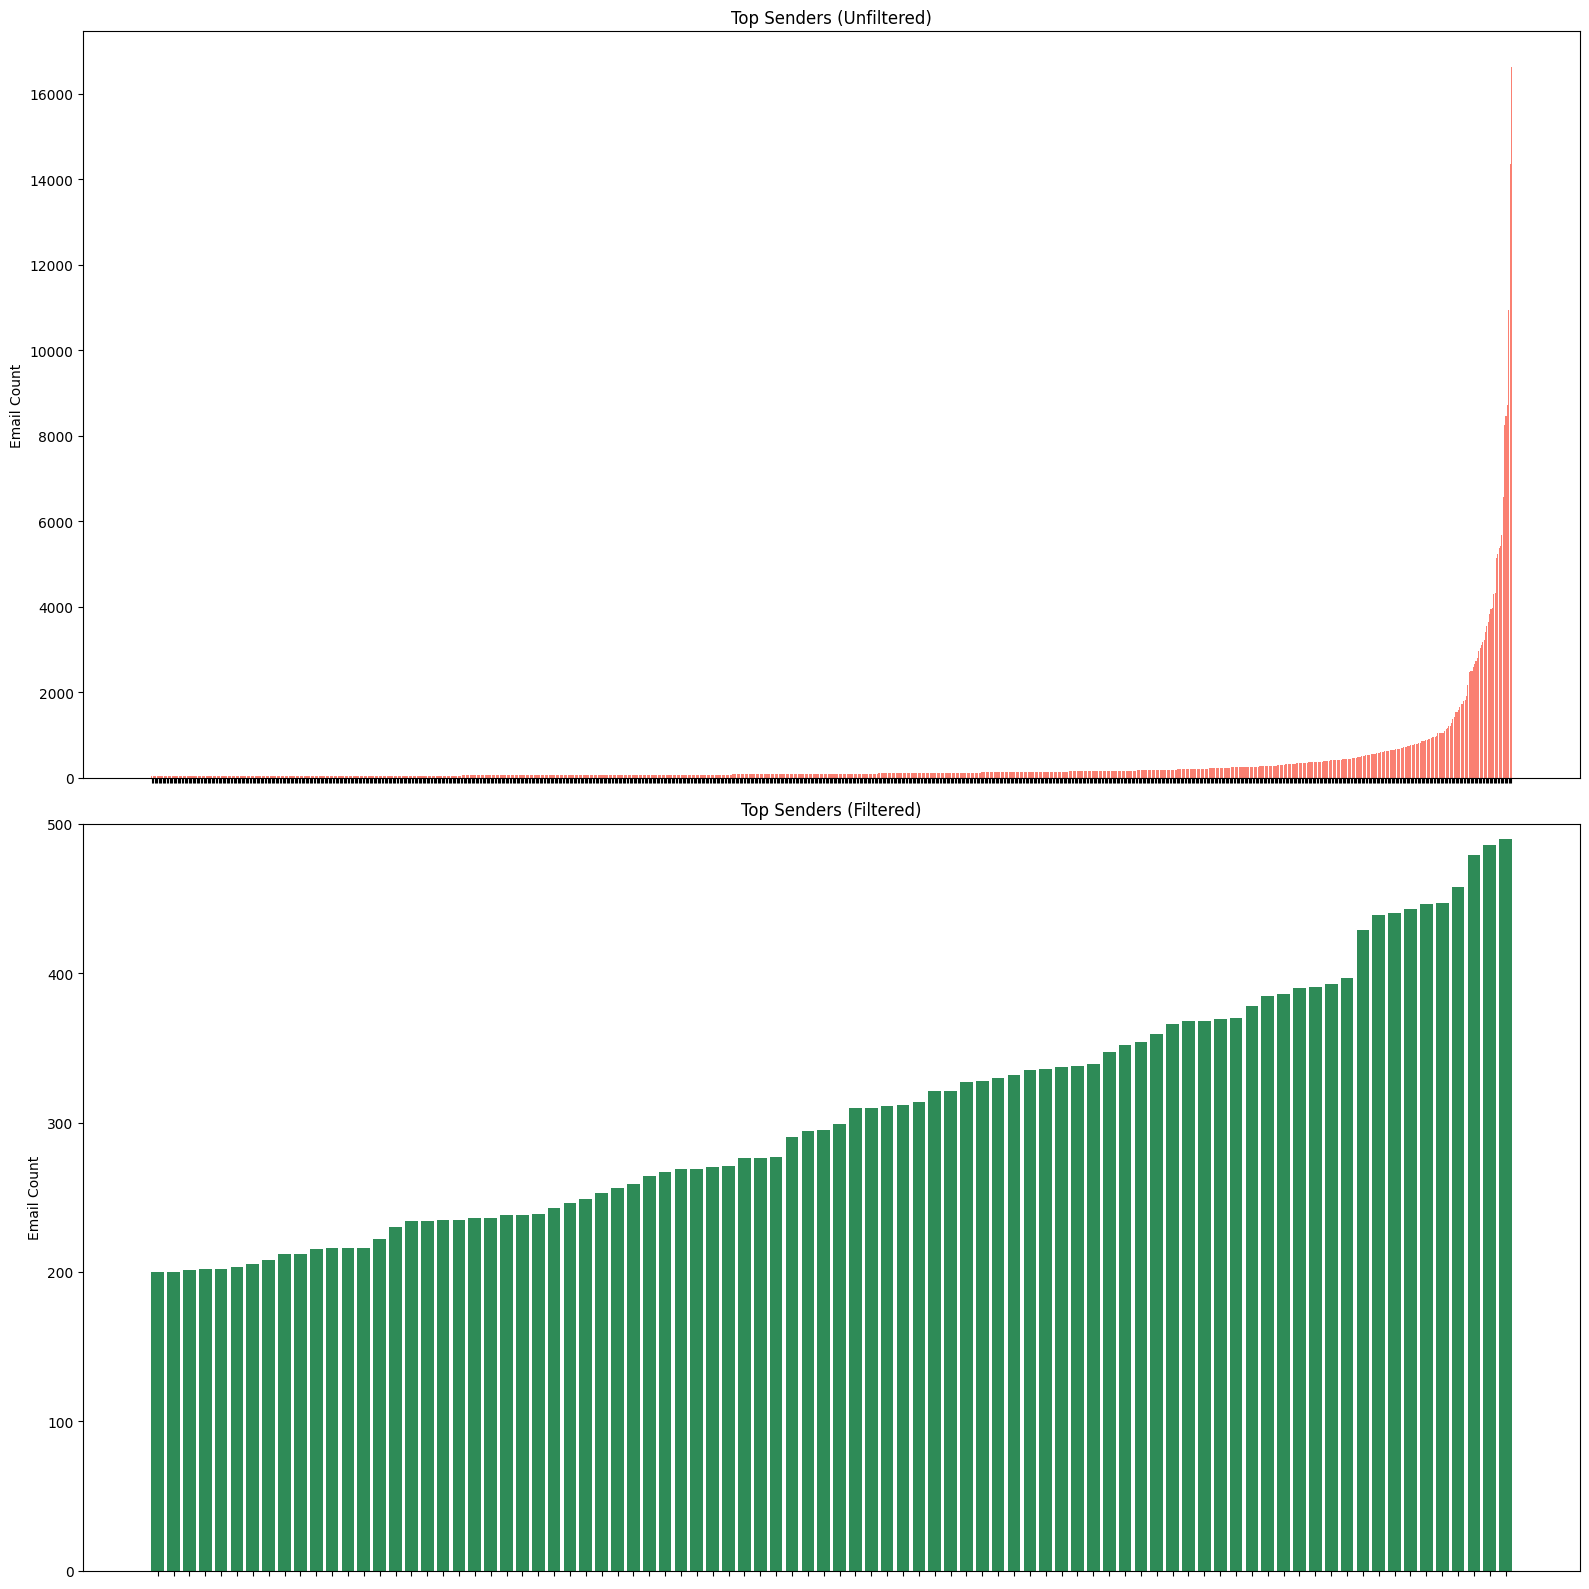

In [27]:
# Analysis of filtered vs unfiltered data
print(f"Unfiltered: {len(x)} emails from {len(set(y))} users")
print(f"Filtered:   {len(x_filtered)} emails from {len(set(y_filtered))} users with {min_emails}-{max_emails} emails")

top_threshold = 1000 # Lower = faster charts, showing less data
# Print top filtered senders
if top_threshold > len(set(y_filtered)):
    print(f"\nFiltered senders ({len(set(y_filtered))}):")
else:
    print(f"\nFiltered senders ({top_threshold}):")
for sender, email_count in count_filtered.most_common(top_threshold):
    print(f"{sender}: {email_count} emails")

# Extract top data for plotting
top_unfiltered = count.most_common(top_threshold)
top_filtered = count_filtered.most_common(top_threshold)

# Separate into sender and count lists
senders_unf, counts_unf = zip(*top_unfiltered)
senders_filt, counts_filt = zip(*top_filtered)

# Plot data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))

# Unfiltered plot
ax1.bar(senders_unf[::-1], counts_unf[::-1], color='salmon')
ax1.set_title('Top Senders (Unfiltered)')
ax1.set_ylabel('Email Count')
ax1.set_xticklabels([])

# Filtered plot
ax2.bar(senders_filt[::-1], counts_filt[::-1], color='seagreen')
ax2.set_title('Top Senders (Filtered)')
ax2.set_ylabel('Email Count')
ax2.set_xticklabels([])
ax2.set_ylim(0, 500)

plt.tight_layout()
plt.show()

In [28]:
# Encode y (senders)
y_encoded = le.fit_transform(y_filtered)

# Split Data
# Split (train+val) vs test
x_temp, x_test, y_temp, y_test = train_test_split(x_filtered, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Split train vs val
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Strip paths for all x splits
x_train = [msg for msg, _ in x_train]
x_val   = [msg for msg, _ in x_val]
x_test  = [msg for msg, _ in x_test]

print(f"x_train: {len(x_train)} samples")
print(f"x_test:  {len(x_test)} samples")
print(f"x_val:   {len(x_val)} samples")

x_train: 7908 samples
x_test:  2637 samples
x_val:   2636 samples


## 2.1. Processing for Non-DL models

In [29]:
# Extra processing for non-DL models
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(x_train)
X_val   = vectorizer.transform(x_val)
X_test  = vectorizer.transform(x_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"X_val: {X_val.shape}")

X_train: (7908, 42837)
X_test: (2637, 42837)
X_val: (2636, 42837)


## 2.2. Processing for DL models

In [30]:
# Extra processing for DL models
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>", lower=False)
tokenizer.fit_on_texts(x_train)

X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq  = tokenizer.texts_to_sequences(x_test)
X_val_seq   = tokenizer.texts_to_sequences(x_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=300, padding='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=300, padding='post')
X_val_pad   = pad_sequences(X_val_seq, maxlen=300, padding='post')

print(f"X_train_seq: {len(X_train_seq)}")
print(f"X_test_seq: {len(X_test_seq)}")
print(f"X_val_seq: {len(X_val_seq)}")
print(f"X_train_pad: {len(X_train_pad)}")
print(f"X_test_pad: {len(X_test_pad)}")
print(f"X_val_pad: {len(X_val_pad)}")

X_train_seq: 7908
X_test_seq: 2637
X_val_seq: 2636
X_train_pad: 7908
X_test_pad: 2637
X_val_pad: 2636


# 3. ML Models

## 3.1 Random Forest

In [20]:
# Create and train the model
n = 100
r = 42

rf_model = RandomForestClassifier(n_estimators = n, random_state = r)
rf_model.fit(X_train, y_train)

# Predict
train_preds = rf_model.predict(X_train)
val_preds = rf_model.predict(X_val)
test_preds = rf_model.predict(X_test)

# Evaluate
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, val_preds)
test_acc = accuracy_score(y_test, test_preds)
print('model fitted')

model fitted


Train Accuracy: 1.0000
Validation Accuracy: 0.7705
Test Accuracy: 0.7819


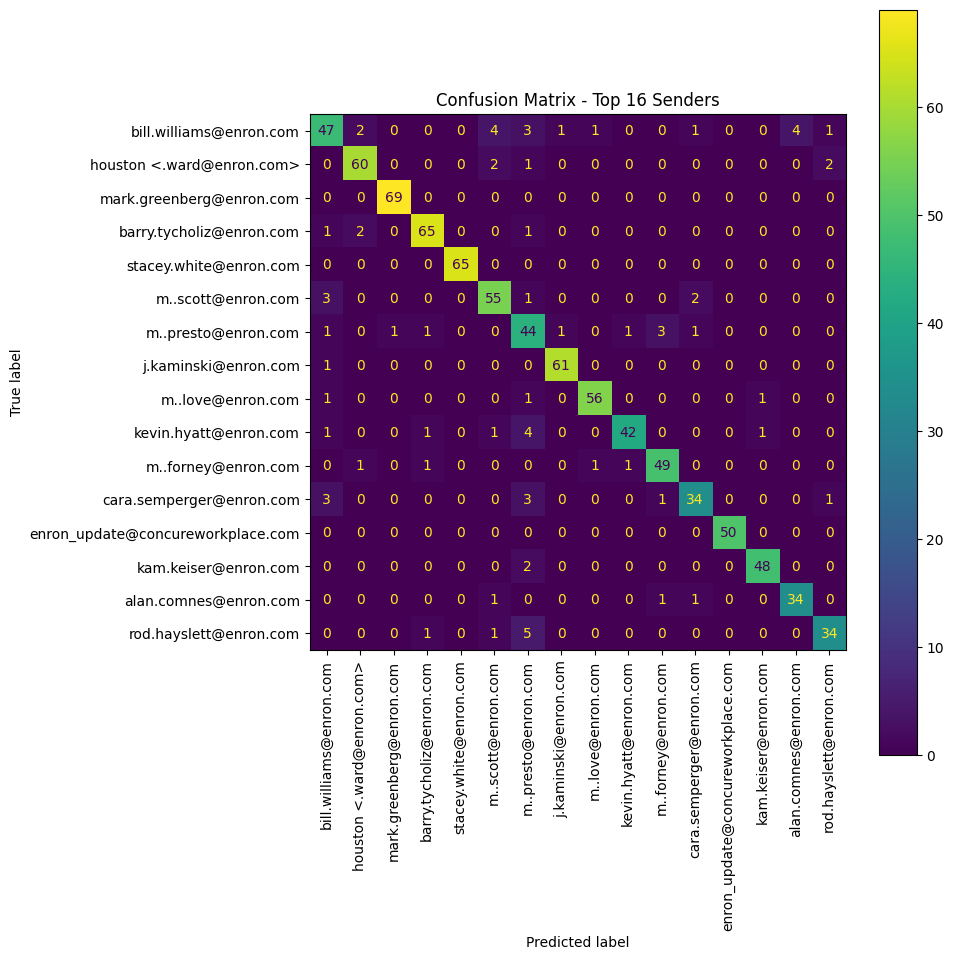

Full cm exported to 'confusion_matrix_full.xlsx'


In [29]:
# Evaluate
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Create subset confusion matrix
top_N = 16
top_class_indices = [cls for cls, _ in Counter(y_test).most_common(top_N)]
mask = np.isin(y_test, top_class_indices)

X_test_top = X_test[mask]
y_test_top = y_test[mask]
y_pred_top = rf_model.predict(X_test_top)

cm = confusion_matrix(y_test_top, y_pred_top, labels=top_class_indices)
class_labels = le.classes_[top_class_indices]

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(ax=ax, cmap='viridis', xticks_rotation=90)
ax.set_title(f"Confusion Matrix - Top {top_N} Senders")
plt.tight_layout()
plt.show()

# Create full confusion matrix and export to excel
y_pred_full = rf_model.predict(X_test)
cm_full = confusion_matrix(y_test, y_pred_full)
cm_df = pd.DataFrame(cm_full, index=le.classes_, columns=le.classes_)

# Export to Excel
cm_df.to_excel("confusion_matrix_full.xlsx")
print("Full cm exported to 'confusion_matrix_full.xlsx'")

## 3.2 Long Short-Term Memory

## 3.3 Support Vector Machine

In [39]:
from sklearn.model_selection import GridSearchCV

#Vectorise using TF-IDF
vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    max_features=10000,
    ngram_range=(1, 2)
)
X_train = vectorizer.fit_transform(x_train)
X_val   = vectorizer.transform(x_val)
X_test  = vectorizer.transform(x_test)

# Create and train SVM model
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(
    estimator=LinearSVC(dual=False, class_weight='balanced', max_iter=5000),
    param_grid=param_grid,
    cv=5,
    verbose=1,
    n_jobs=-1  # use all cores
)
grid.fit(X_train, y_train)

# Replace the model with the best one
svm_model = grid.best_estimator_

#Predict
train_preds = svm_model.predict(X_train)
val_preds   = svm_model.predict(X_val)
test_preds  = svm_model.predict(X_test)

# Evaluate
train_acc = accuracy_score(y_train, train_preds)
val_acc   = accuracy_score(y_val, val_preds)
test_acc  = accuracy_score(y_test, test_preds)
print("SVM model fitted\n")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")
print("SVM parameters")
print("Best C:", grid.best_params_['C'])


Fitting 5 folds for each of 4 candidates, totalling 20 fits
SVM model fitted

Train Accuracy: 0.9985
Validation Accuracy: 0.7959
Test Accuracy: 0.8244

SVM parameters
Best C: 1


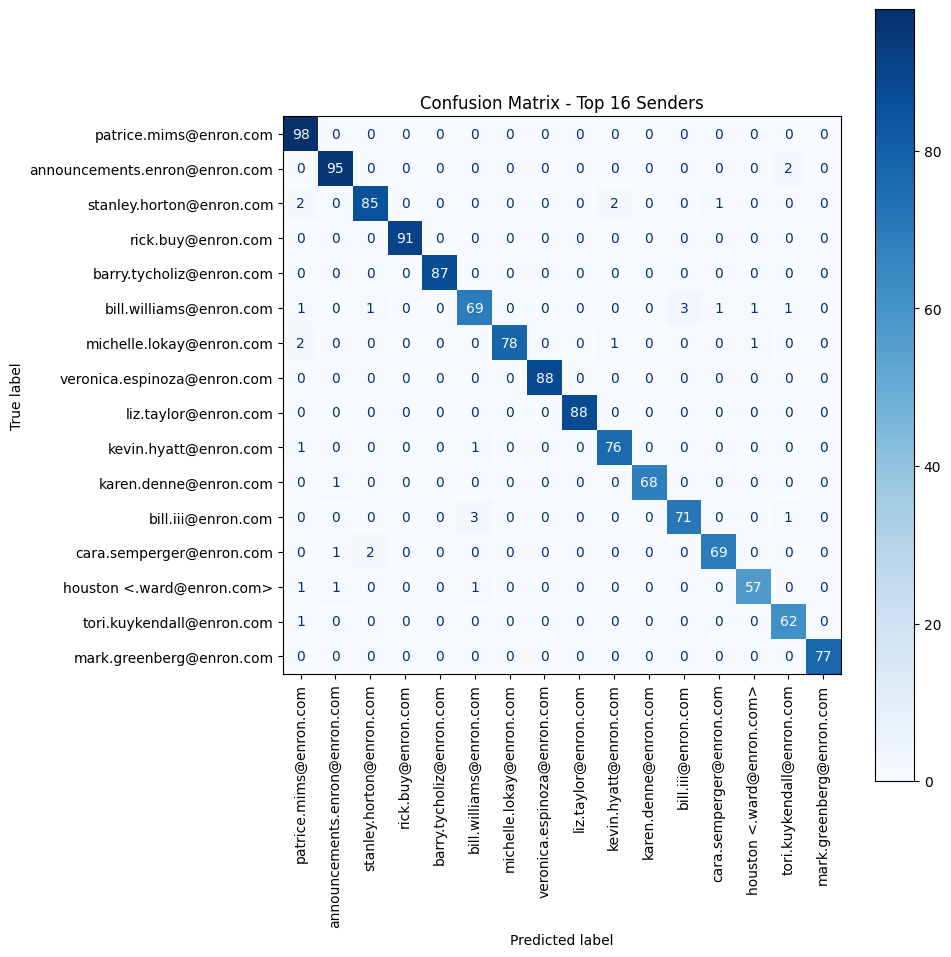

In [22]:
# Top N classes by test set frequency
top_N = 16
top_class_indices = [cls for cls, _ in Counter(y_test).most_common(top_N)]
mask = np.isin(y_test, top_class_indices)

X_test_top = X_test[mask]
y_test_top = y_test[mask]
y_pred_top = svm_model.predict(X_test_top)

cm = confusion_matrix(y_test_top, y_pred_top, labels=top_class_indices)
class_labels = le.classes_[top_class_indices]

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
ax.set_title(f"Confusion Matrix - Top {top_N} Senders")
plt.tight_layout()
plt.show()


In [23]:
y_pred_full = svm_model.predict(X_test)
cm_full = confusion_matrix(y_test, y_pred_full)
cm_df = pd.DataFrame(cm_full, index=le.classes_, columns=le.classes_)

# Save to Excel
cm_df.to_excel("confusion_matrix_svm_full.xlsx")
print("Full SVM confusion matrix exported to 'confusion_matrix_svm_full.xlsx'")


Full SVM confusion matrix exported to 'confusion_matrix_svm_full.xlsx'


## 3.4 Transformer-based Model (BERT)